**The Problem Statement**

Company XYZ sells a software for 39 usd. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (39 usd), while a random sample of 33% users a higher price (59 usd). 


The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. 
Especially he asked you the following questions:
Should the company sell its software for 39 usd or 59 usd?


The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
(Bonus) The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why


In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

# Load Data

In [2]:
user_table = pd.read_csv('user_table.csv')
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [4]:
#check null values

user_table.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [5]:
test_results = pd.read_csv('test_results.csv')
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [7]:
#check null values

test_results.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

We can merge both these tables using user_id, since the ultimate goal is to figure out which price would be better: 39 or 59 usd

# Data Preprocessing

In [8]:
#Number of unique user ids in user_table
user_table.user_id.nunique()

275616

In [9]:
#Number of unique user ids in test_results
test_results.user_id.nunique()

316800

Since there are more unique ids in test_results, we left join test_results and user_table

In [10]:
data = pd.merge(left = test_results, right = user_table, how= 'left', on='user_id' )
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [11]:
#there will be some null values, becuase of the left join
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

We need to make sure that test = 0 corresponds to price = 39, and test = 1 corresponds to price = 59

In [12]:
data[['price', 'test', 'user_id']].groupby(['test','price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

210 people have test = 0 when price = 59, and 155 people have test = 1 when price = 39

In [13]:
#keep valid data
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [14]:
#new revenue column

data['revenue'] = data['price'] * data['converted']

In [15]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [16]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

# Explanatory Data Analysis

## Source

In [17]:
#check randomness

rand = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize = True)).unstack()
rand

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


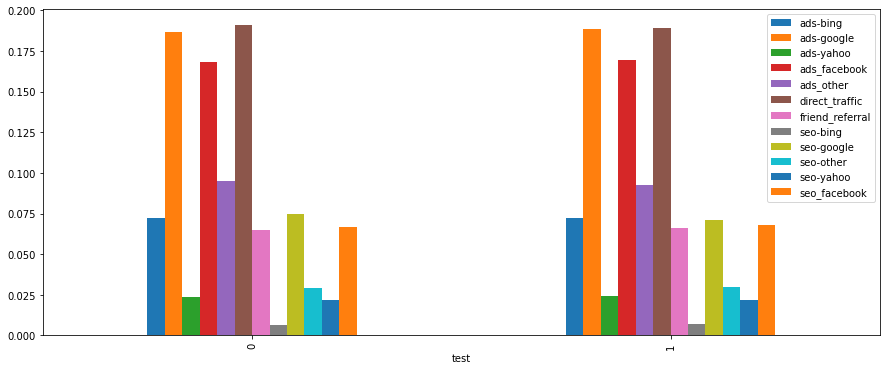

In [18]:
#visualize

fig, ax = plt.subplots(figsize = (15,6))
rand.plot(kind = 'bar', ax= ax)
plt.show()

In [19]:
count = data[['source', 'test','revenue']].groupby(['source','test']).count().reset_index()
count.head(5)

,source,test,revenue
0,ads-bing,0,14584
1,ads-bing,1,8247
2,ads-google,0,37845
3,ads-google,1,21497
4,ads-yahoo,0,4812


In [20]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [21]:
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517
count.head()

,source,test,revenue
0,ads-bing,0,0.072014
1,ads-bing,1,0.072394
2,ads-google,0,0.186873
3,ads-google,1,0.188706
4,ads-yahoo,0,0.023761


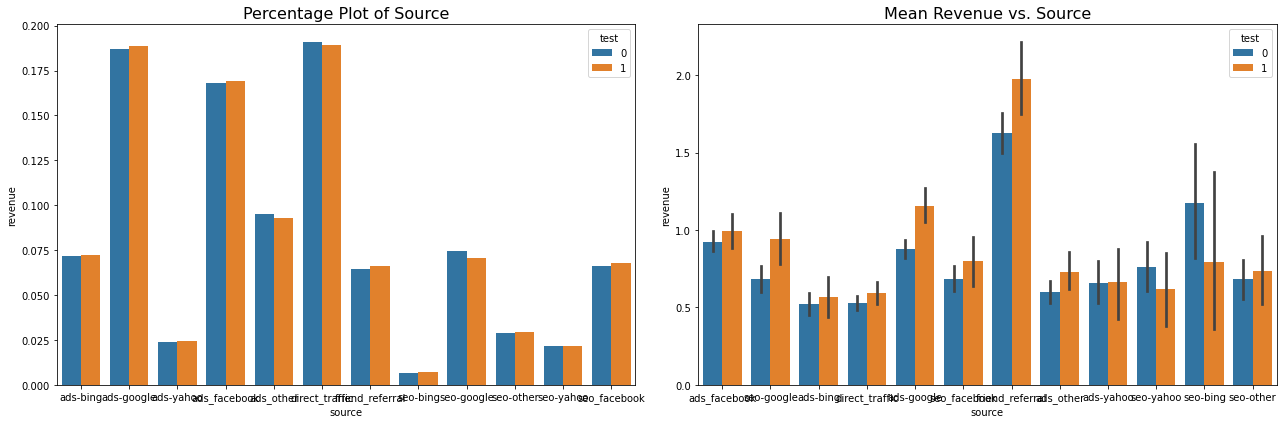

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()

## Device

In [23]:
rand = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize = True)).unstack()
rand

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


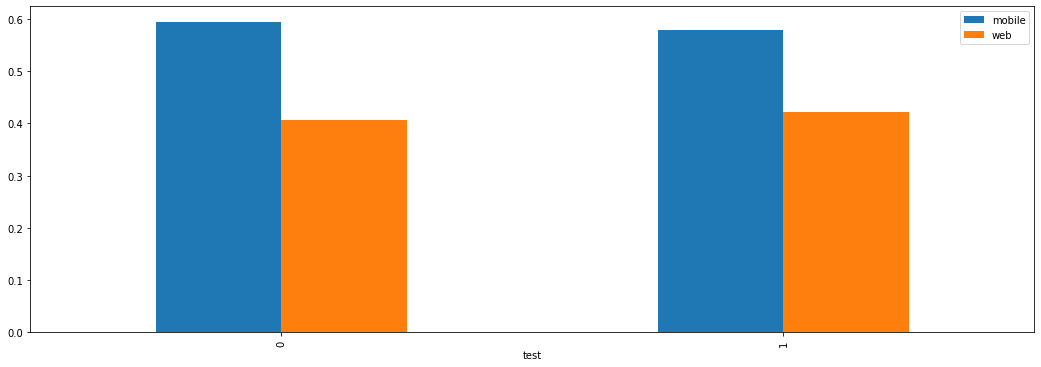

In [24]:
fig, ax = plt.subplots(figsize = (18,6))
rand.plot(kind ='bar', ax= ax)
plt.show()

In [25]:
count = data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517


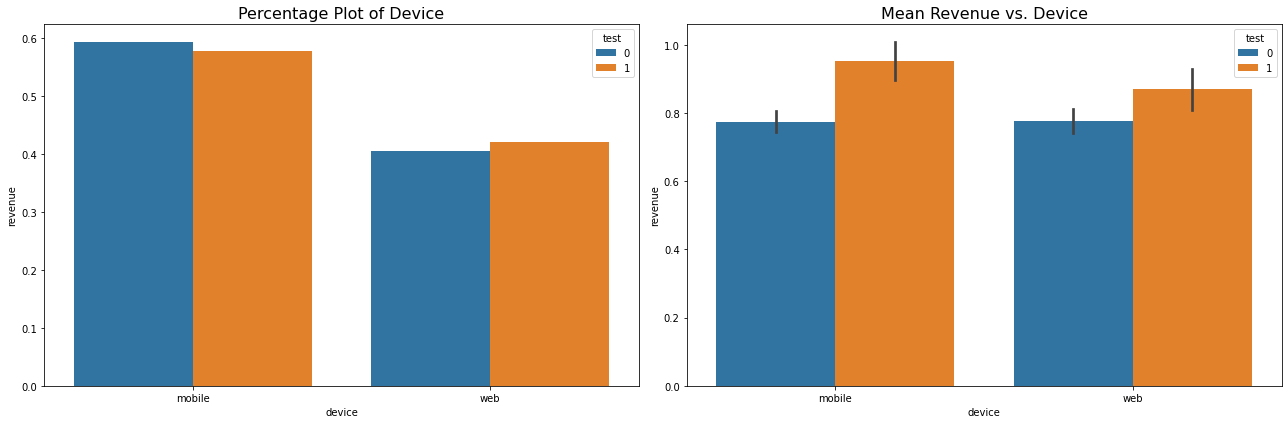

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

## Operating system


In [27]:
rand = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize = True)).unstack()

In [28]:
rand

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


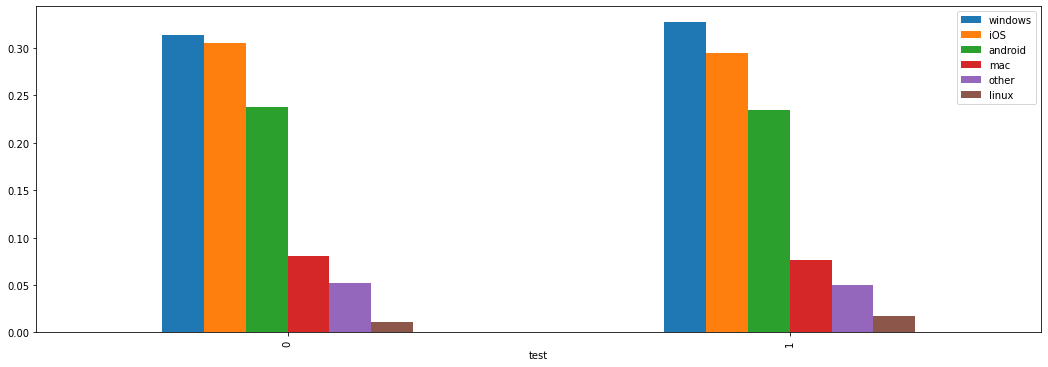

In [29]:
fig, ax = plt.subplots(figsize = (18,6))
rand.plot(kind= 'bar', ax=ax)
plt.show()

In [30]:
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517


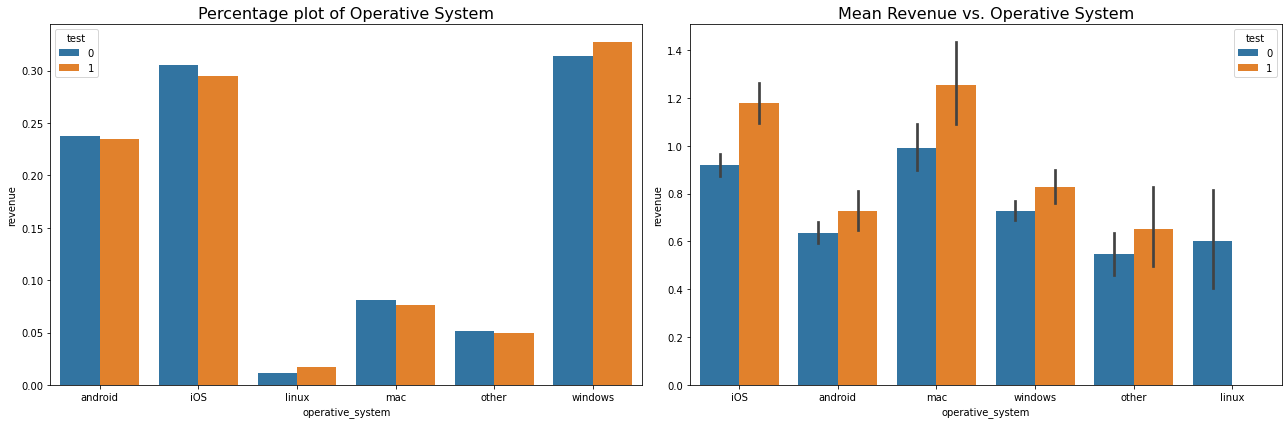

In [31]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (18,6))
sns.barplot(x = 'operative_system', y = 'revenue', hue = 'test', data=count, ax = ax[0])
ax[0].set_title('Percentage plot of Operative System', fontsize = 16)

sns.barplot(x = 'operative_system', y = 'revenue', hue = 'test', data=data, ax = ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize = 16)

plt.tight_layout()

plt.show()

For operative system and device the test is not entirely randomized

# Question 1

In [32]:
#Conversion rate for A/B testing

data[['test','converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


Lower price has higher conversion rate

In [33]:
#Revenue for A/B Testing

data[['test','revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Higher price generates higher revenue

Hypothesis Testing: Null Hypothesis H0: Experimental group's average revenue is less than or equal to control groups average revenue

In [34]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


We can reject the null hypothesis (low p value). So, experimental groups average revenue is larger than that of the control group.

# Question 2

## Source

In [35]:
data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


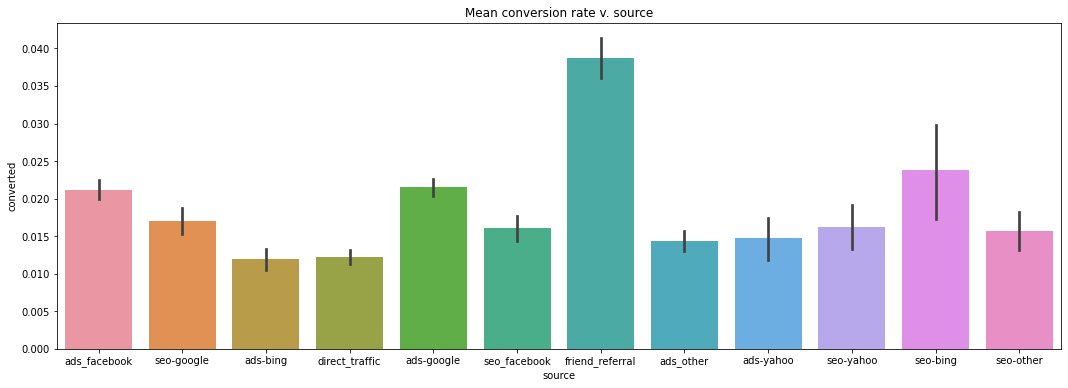

In [36]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = 'source', y= 'converted',  data= data, ax = ax)
ax.set_title('Mean conversion rate v. source')
plt.show()

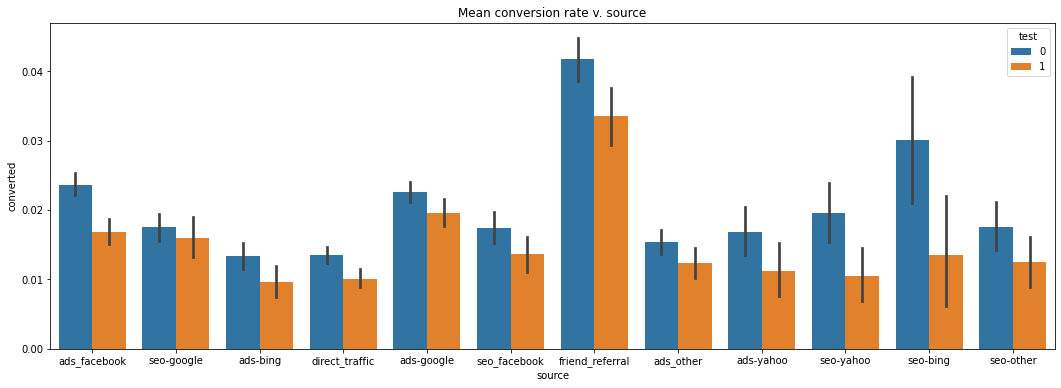

In [37]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = 'source', y= 'converted', hue= 'test',data= data, ax = ax)
ax.set_title('Mean conversion rate v. source')
plt.show()

Friend referrals have high conversion rates, followed by targetted google ads.

## Device

In [38]:
data.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


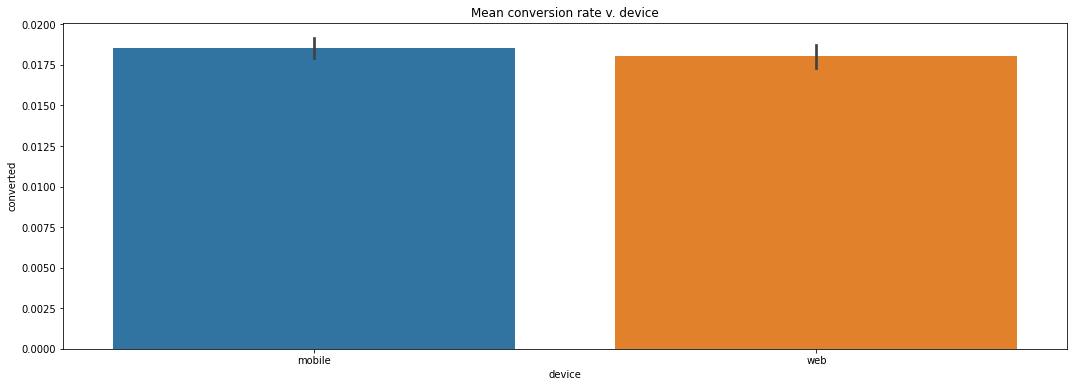

In [39]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = 'device', y= 'converted',  data= data, ax = ax)
ax.set_title('Mean conversion rate v. device')
plt.show()

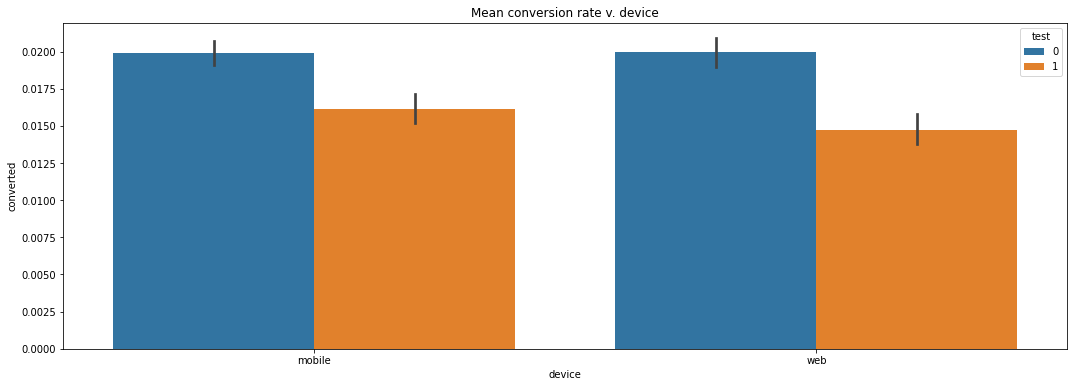

In [40]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = 'device', y= 'converted', hue= 'test',data= data, ax = ax)
ax.set_title('Mean conversion rate v. device')
plt.show()

Device has no significant effect on conversion rates

## Operating System

In [41]:
data.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


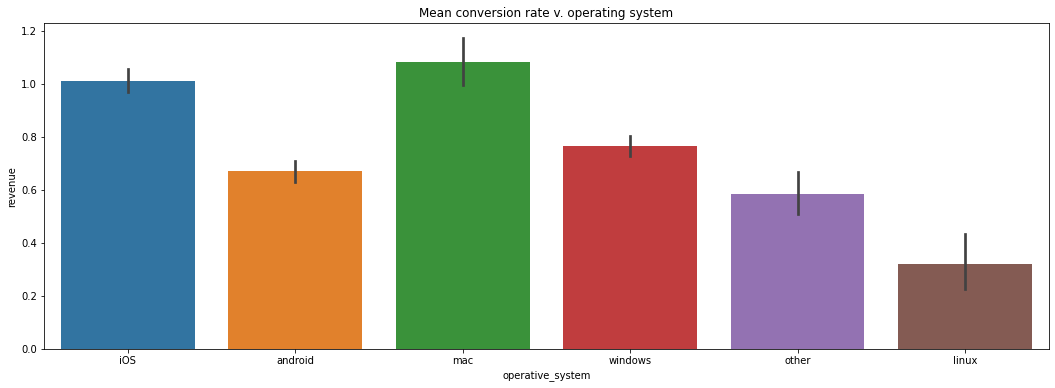

In [42]:
fig, ax = plt.subplots(figsize = (18,6))
sns.barplot(x = 'operative_system', y = 'revenue', data=data, ax=ax)
ax.set_title('Mean conversion rate v. operating system')
plt.show()

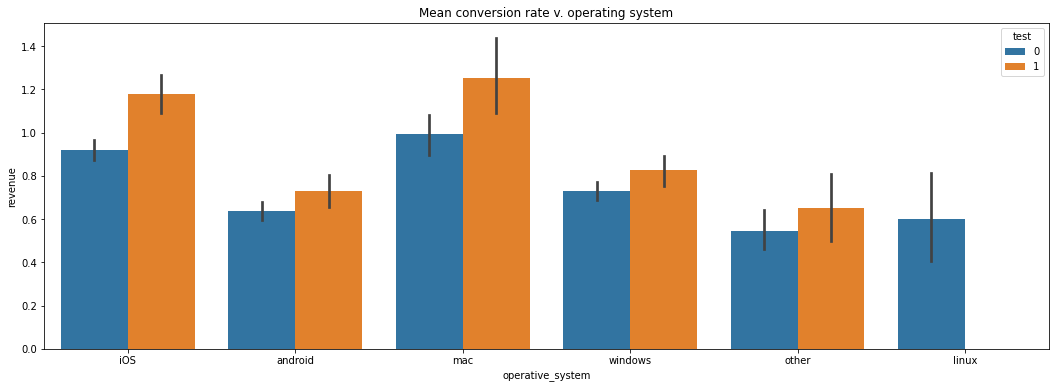

In [43]:
fig, ax = plt.subplots(figsize = (18,6))
sns.barplot(x = 'operative_system', y = 'revenue', hue = 'test',data=data, ax=ax)
ax.set_title('Mean conversion rate v. operating system')
plt.show()

Mac and iOS users have the highest conversion rates